# Customer purchase prediction

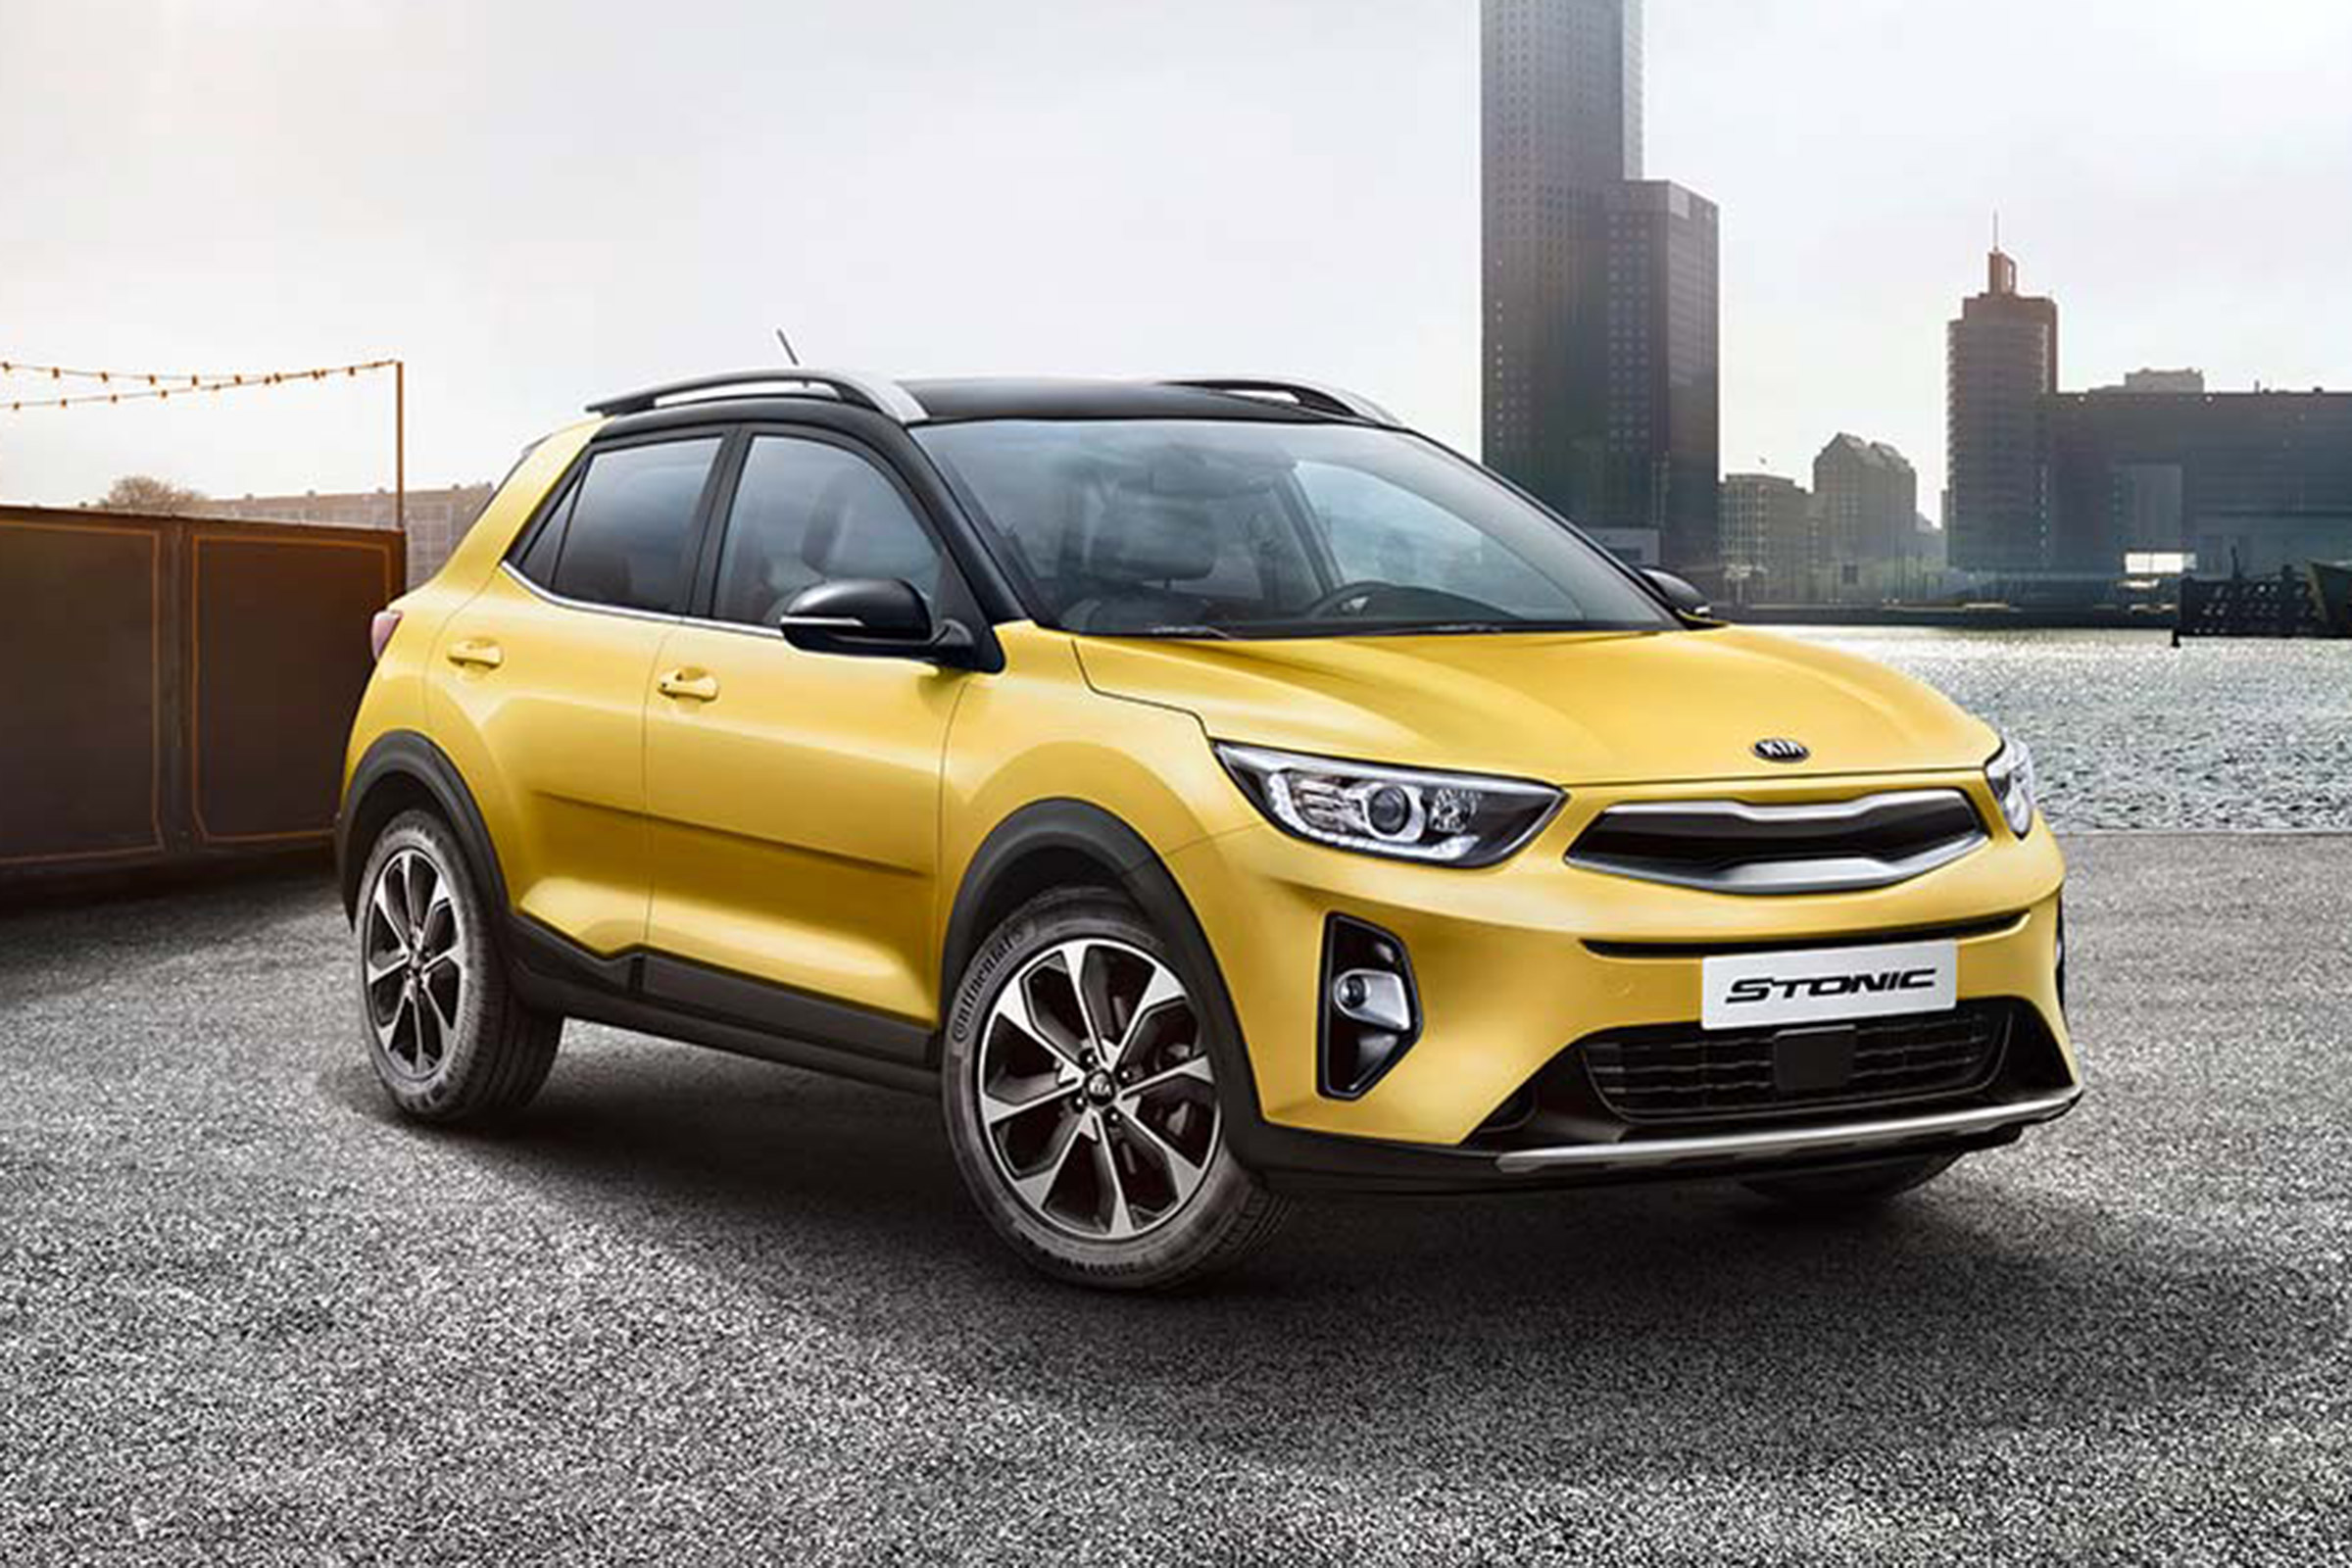

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("suv_data.csv")

### Who are the customers are we to target with our new SUV ad?

#### Previous customer records

In [3]:
dataset.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


## Data Visualization

<AxesSubplot:xlabel='Gender', ylabel='count'>

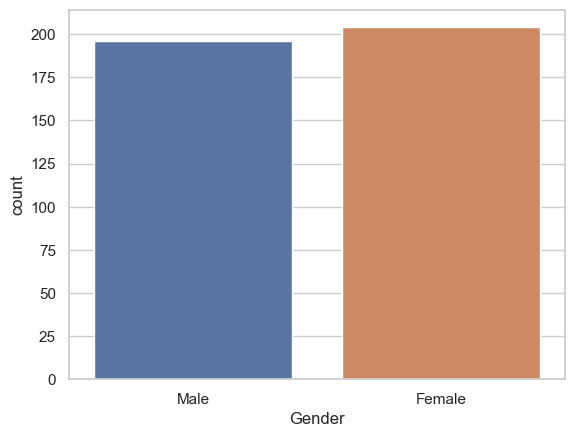

In [4]:
sns.countplot(x=dataset["Gender"])

<AxesSubplot:xlabel='Gender', ylabel='count'>

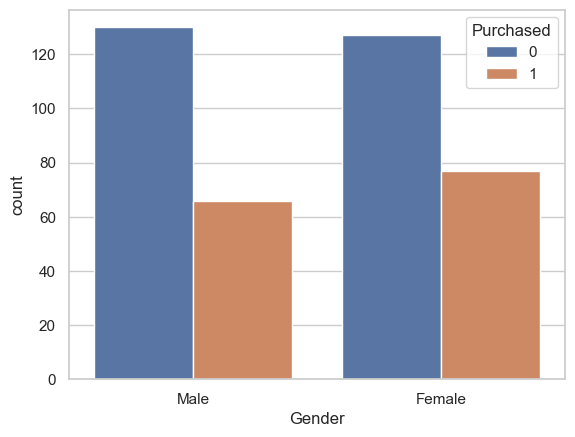

In [5]:
sns.countplot(data=dataset, x="Gender", hue="Purchased")

<AxesSubplot:xlabel='Age', ylabel='Count'>

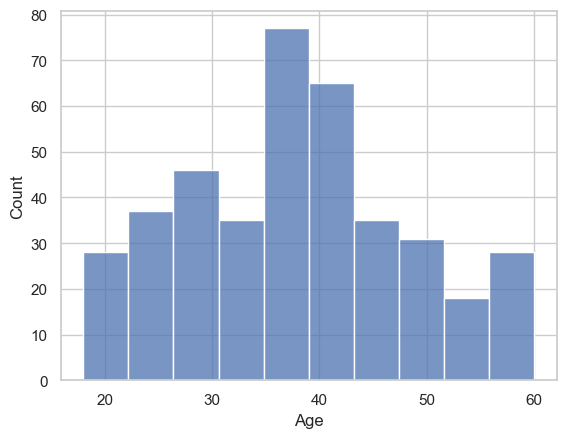

In [6]:
sns.histplot(data = dataset, x = 'Age')

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Count'>

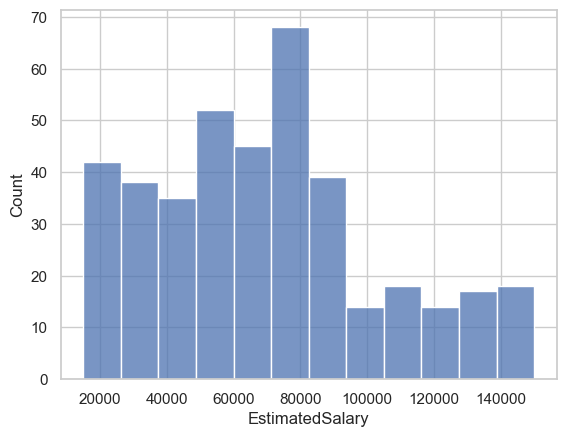

In [7]:
sns.histplot(x=dataset["EstimatedSalary"])

## Data preprocessing

### Split the data into Training set and Test set

In [8]:
X = dataset.iloc[:,[2,3]].values
y = dataset.iloc[:,4].values

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

### Feature scaling 

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Classification model

### Training the Logistic Regression model

In [11]:
from sklearn.linear_model import LogisticRegression
classifier_lg = LogisticRegression(random_state = 0)
classifier_lg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [12]:
y_pred_lg = classifier_lg.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy_lg = accuracy_score(y_test, y_pred_lg)*100
precision_lg = precision_score(y_test, y_pred_lg)*100
score_lg = f1_score(y_test, y_pred_lg)*100
recall_lg = recall_score(y_test, y_pred_lg)*100

print('The accuracy of the Logistic Regression:', accuracy_lg)

The accuracy of the Logistic Regression: 89.0


### Precision-Recall curve

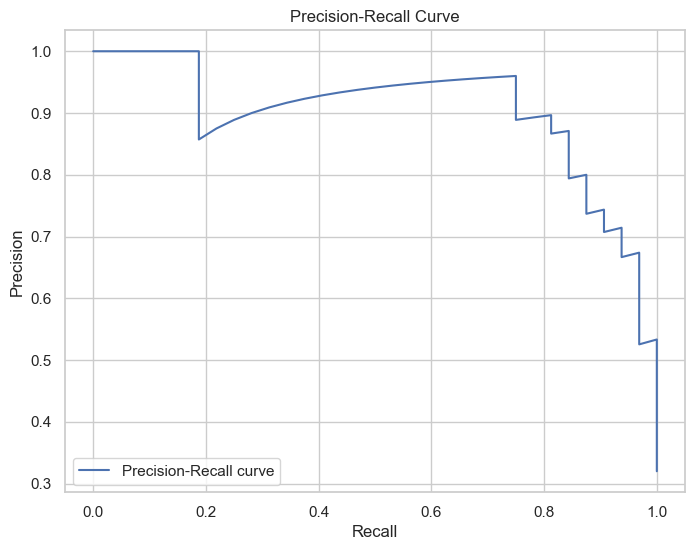

In [14]:
from sklearn.metrics import precision_recall_curve

# Suppose you have your model (lg) and your data (X_test, y_test)
y_scores = classifier_lg.predict_proba(X_test)[:, 1]  # get the probability estimates of the positive class

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Training the SVM Kernel model

In [15]:
from sklearn.svm import SVC
classifier_svm = SVC(kernel = 'rbf', probability=True, random_state = 0)
classifier_svm.fit(X_train, y_train)

SVC(probability=True, random_state=0)

In [16]:
y_pred_svm = classifier_svm.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy_svm = accuracy_score(y_test, y_pred_svm)*100
precision_svm = precision_score(y_test, y_pred_svm)*100
score_svm = f1_score(y_test, y_pred_svm)*100
recall_svm = recall_score(y_test, y_pred_svm)*100

print('The accuracy of the SVM Kernel:', accuracy_svm)

The accuracy of the SVM Kernel: 93.0


#### Receiver Operating Characteristic

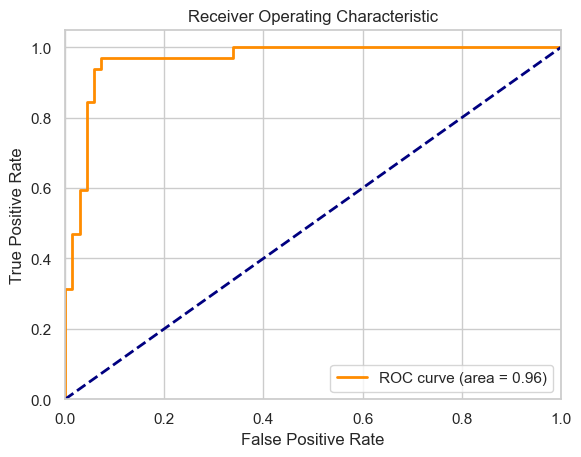

In [18]:
from sklearn.metrics import roc_curve, auc

# Fit the model on the training data
classifier_svm.fit(X_train, y_train)

# Predict the probabilities of the positive class
y_prob = classifier_svm.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Comparing models

In [19]:
# Define the model names and accuracy values
model_names = ['Logistic Regression', 'SVM Kernel']
accuracy_values = [accuracy_lg, accuracy_svm]
precision_values = [precision_lg, precision_svm]
f1_score_values = [score_lg, score_svm]
recall_values = [recall_lg, recall_svm]

# Create a dictionary with the data
data = {'Model': model_names,
        'Accuracy': accuracy_values,
        'Precision': precision_values,
        'Recall': recall_values,
        'f1_score': f1_score_values}

# Create the DataFrame
df = pd.DataFrame(data)

In [20]:
df

,Model,Accuracy,Precision,Recall,f1_score
0,Logistic Regression,89.0,88.888889,75.000,81.355932
1,SVM Kernel,93.0,87.878788,90.625,89.230769


## K-Fold Cross Validation

In [21]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_svm, X = X_train, y = y_train, cv = 10) 
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 90.33 %
Standard Deviation: 6.57 %


### SHAP Feature Importance

##### Global and Local Distribution

In [22]:
import shap

# Create a smaller subset of background data
background_subset = shap.sample(X_train, 50)

# Create the explainer object with the SVM model and the subset of background data
explainer = shap.KernelExplainer(model=classifier_svm.predict, data=background_subset, link="identity")

# Calculate shap_values for the first 50 instances in X_test
shap_values = explainer.shap_values(X_test[:50])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

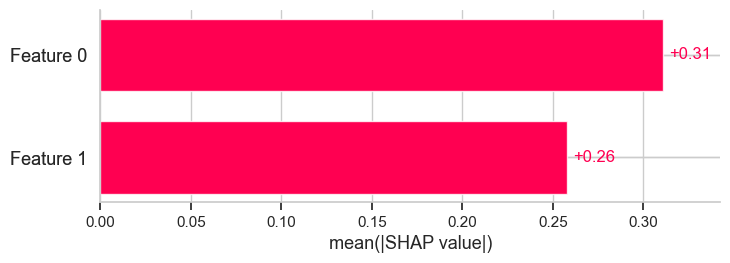

In [23]:
# Summarize the SHAP values in a SHAP values object
shap_values_object = explainer(X_test[:50])

# Create the bar plot
shap.plots.bar(shap_values_object)

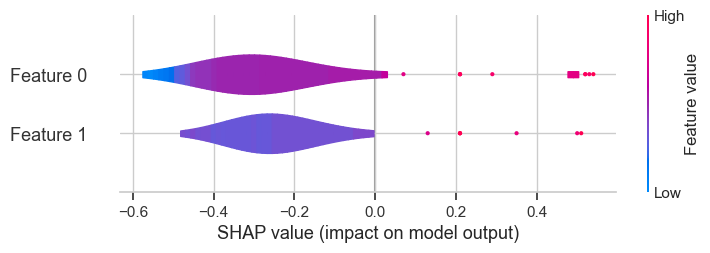

In [24]:
shap.plots.violin(shap_values_object)

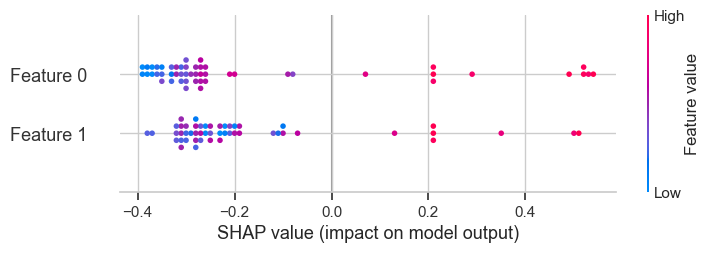

In [25]:
shap.plots.beeswarm(shap_values_object)

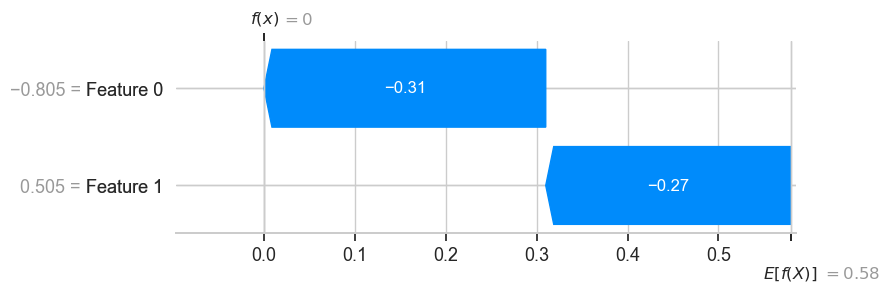

In [26]:
shap.plots.waterfall(shap_values_object[0])

## Single Prediction using SVM Kernel model

### Case study: Using the SVM model at a 93% accuracy, most important feature is "Age".
#### A customer Age 25 with an estimated salary of $120000 would purchase a new car =  True/False 

In [27]:
prediction = classifier_svm.predict(sc.transform([[25, 120000]]))

print('The customer is predicted to purchase a new car:', prediction > 0.5)

The customer is predicted to purchase a new car: [ True]
